In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats



In [ ]:
# Define constants
DATASET_PATH = r"C:\Users\hp\OneDrive\Desktop\FYP 2021\Pakistan Sign Language Urdu Alphabets"
IMG_SIZE = 224  # Image size for MobileNetV2
BATCH_SIZE = 32

# Get class names
class_names = [directory for directory in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, directory))]

# Function to get image paths and labels
def get_image_paths_and_labels(dataset_path, class_names):
    image_paths = []
    labels = []
    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        for file_name in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, file_name))
            labels.append(idx)
    return np.array(image_paths), np.array(labels)

# Load image paths and labels
image_paths, labels = get_image_paths_and_labels(DATASET_PATH, class_names)

from sklearn.model_selection import train_test_split

# Split dataset into training, validation, and test sets
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)



In [4]:
# ✅ Fixed Augmentation Function
def augment_image(image):
    image = tf.image.random_brightness(image, max_delta=0.2)  # Brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Contrast
    image = tf.image.random_hue(image, max_delta=0.1)  # Hue
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)  # Saturation

    # Add Gaussian noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05, dtype=tf.float32)
    image = tf.clip_by_value(image + noise, 0.0, 1.0)

    # Apply Gaussian blur to 50% of images
    if tf.random.uniform(()) < 0.6:
        kernel = tf.constant([
            [0.05, 0.2, 0.05],
            [0.2,  0.2, 0.2],
            [0.05, 0.2, 0.05]
        ], dtype=tf.float32)

        kernel = tf.reshape(kernel, [3, 3, 1, 1])  # Convert to 4D tensor
        kernel = tf.tile(kernel, [1, 1, 3, 1])  # Expand for RGB channels

        image = tf.expand_dims(image, axis=0)  # Add batch dimension
        image = tf.nn.depthwise_conv2d(image, kernel, strides=[1, 1, 1, 1], padding='SAME')
        image = tf.squeeze(image, axis=0)  # Remove batch dimension

    # Apply sharpness reduction to 50% of images
    if tf.random.uniform(()) < 0.5:
        image = tf.image.adjust_gamma(image, gamma=1.2)  # Reduce sharpness

    return image


# Helper function to preprocess data
def preprocess_data(image_path, label, augment=False):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # Normalize
    
    if augment:
        image = augment_image(image)
    
    return image, label



In [5]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(lambda x, y: preprocess_data(x, y, augment=True)).batch(BATCH_SIZE).shuffle(1000).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(preprocess_data).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_dataset = test_dataset.map(preprocess_data).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze the base model



Epoch 1/25
698/698 ━━━━━━━━━━━━━━━━━━━━ 599s 585ms/step - accuracy: 0.3789 - loss: 2.1420 - val_accuracy: 0.7984 - val_loss: 0.6725
Epoch 2/25
698/698 ━━━━━━━━━━━━━━━━━━━━ 603s 565ms/step - accuracy: 0.7215 - loss: 0.7919 - val_accuracy: 0.8590 - val_loss: 0.4874
Epoch 3/25
698/698 ━━━━━━━━━━━━━━━━━━━━ 618s 582ms/step - accuracy: 0.7783 - loss: 0.6248 - val_accuracy: 0.8673 - val_loss: 0.4208
Epoch 4/25
698/698 ━━━━━━━━━━━━━━━━━━━━ 607s 565ms/step - accuracy: 0.8064 - loss: 0.5454 - val_accuracy: 0.8920 - val_loss: 0.3449
Epoch 5/25
698/698 ━━━━━━━━━━━━━━━━━━━━ 590s 564ms/step - accuracy: 0.8236 - loss: 0.5089 - val_accuracy: 0.8902 - val_loss: 0.3494
Epoch 6/25
698/698 ━━━━━━━━━━━━━━━━━━━━ 614s 576ms/step - accuracy: 0.8264 - loss: 0.5000 - val_accuracy: 0.9067 - val_loss: 0.3156
Epoch 7/25
698/698 ━━━━━━━━━━━━━━━━━━━━ 599s 561ms/step - accuracy: 0.8420 - loss: 0.4529 - val_accuracy: 0.9139 - val_loss: 0.2958
Epoch 8/25
698/698 ━━━━━━━━━━━━━━━━━━━━ 641s 571ms/step - accuracy: 0.8466 -

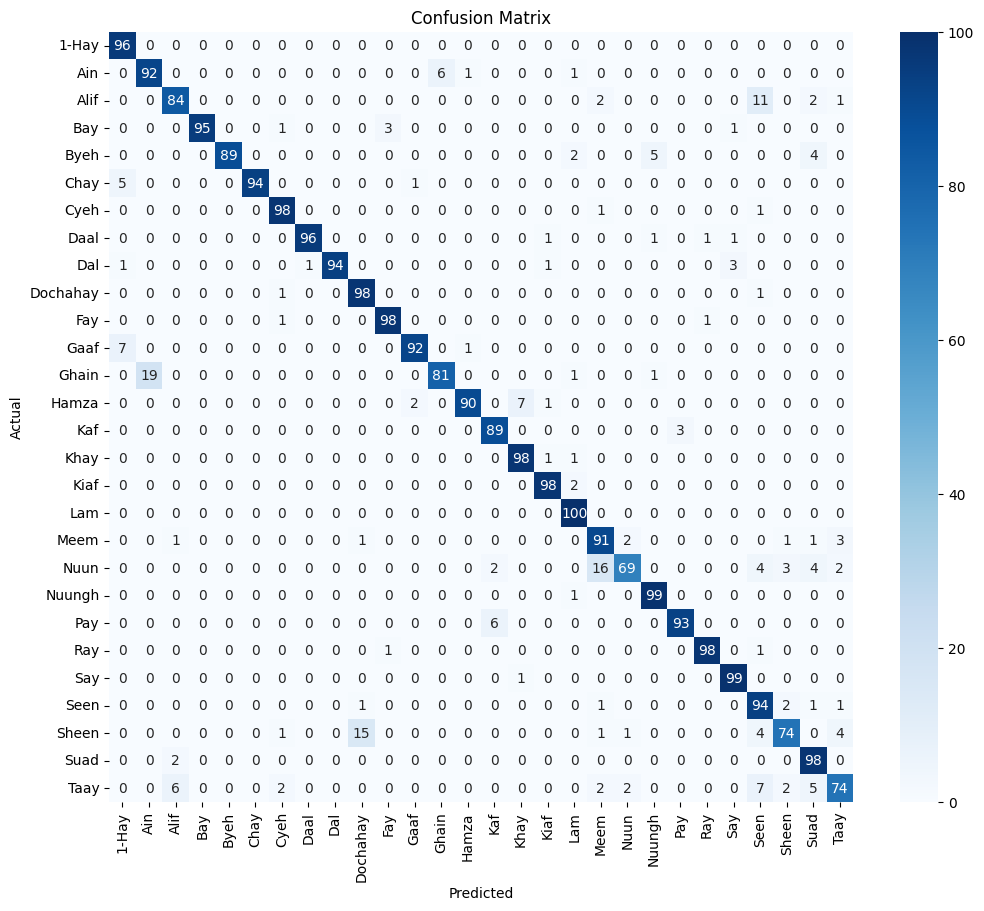

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

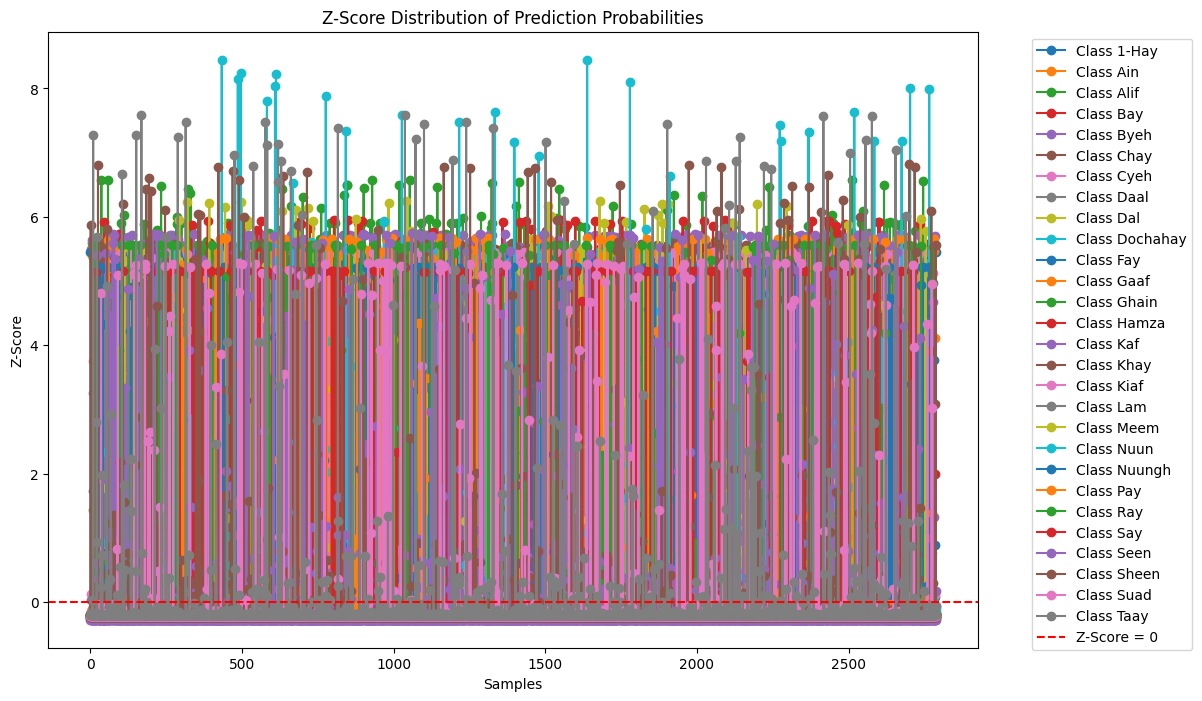

In [6]:
# Add custom layers for the classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(class_names), activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Make predictions on the test dataset
predictions = np.argmax(model.predict(test_dataset), axis=-1)
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Z-Score Graph
probs = np.concatenate([model.predict(x) for x, y in test_dataset])
z_scores = stats.zscore(probs, axis=0)  # Calculate z-scores across the classes
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(class_names):
    plt.plot(z_scores[:, i], label=f'Class {class_name}', marker='o', linestyle='-')
plt.axhline(y=0, color='r', linestyle='--', label='Z-Score = 0')
plt.title('Z-Score Distribution of Prediction Probabilities')
plt.xlabel('Samples')
plt.ylabel('Z-Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [7]:
model.save("new_approach_for_static_with_data_augment_25_epochs.h5")
print("Model saved successfully!")

Model saved successfully!


Found 27885 images belonging to 28 classes.


C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


872/872 ━━━━━━━━━━━━━━━━━━━━ 550s 628ms/step
Model Accuracy: 0.9271

Classification Report:

              precision    recall  f1-score   support

       1-Hay       0.90      0.97      0.93       953
         Ain       0.88      0.94      0.91      1000
        Alif       0.88      0.93      0.90      1000
         Bay       0.98      0.98      0.98      1000
        Byeh       0.99      0.92      0.95      1000
        Chay       0.99      0.97      0.98      1000
        Cyeh       0.92      0.96      0.94      1000
        Daal       0.99      0.94      0.97      1000
         Dal       1.00      0.94      0.97      1000
    Dochahay       0.90      0.96      0.93      1000
         Fay       0.98      0.95      0.97      1000
        Gaaf       0.95      0.91      0.93      1000
       Ghain       0.95      0.87      0.91      1022
       Hamza       0.95      0.93      0.94      1000
         Kaf       0.92      0.98      0.95       925
        Khay       0.95      0.95      0.9

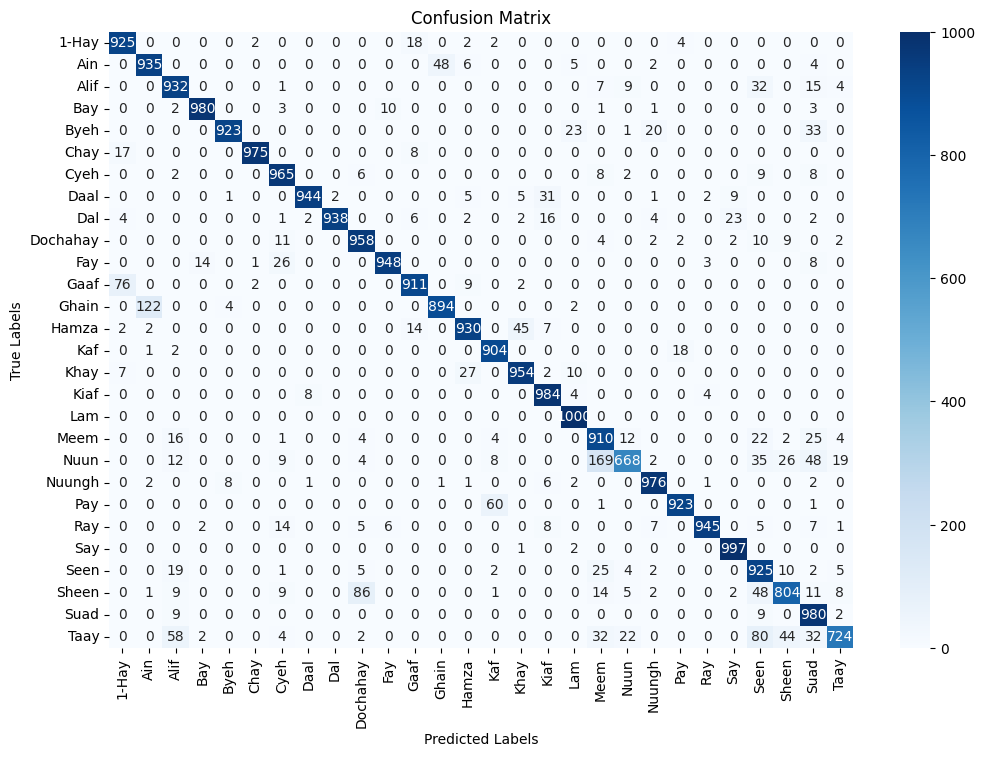

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Load the Trained Model ---
MODEL_PATH = r"C:\Users\hp\OneDrive\Desktop\FYP 2021\codes\new_approach_for_static_with_data_augment_25_epochs.h5"
model = tf.keras.models.load_model(MODEL_PATH)

# --- Data Paths ---
TEST_DATASET_PATH =r"C:\Users\hp\OneDrive\Desktop\FYP 2021\Pakistan Sign Language Urdu Alphabets" # Update this with your test dataset path
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# --- Load Test Data ---
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # No shuffling for proper evaluation
)

# --- Get True Labels ---
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# --- Get Predictions ---
pred_probs = model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)
``
# --- Compute Metrics ---
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Model Accuracy: {accuracy:.4f}\n")

# --- Precision, Recall, F1-Score ---
print("Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=class_labels))

# --- Confusion Matrix ---
conf_matrix = confusion_matrix(true_labels, pred_labels)

# --- Plot Confusion Matrix ---
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


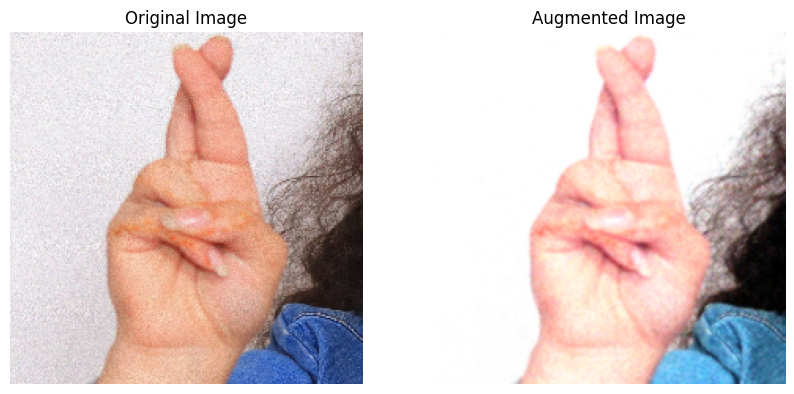

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load test image
TEST_IMAGE_PATH = r"C:\Users\hp\OneDrive\Desktop\FYP 2021\Pakistan Sign Language Urdu Alphabets\Ray\s0251-15ray-Generated-304.jpg"  # Replace with your image path

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))  # Resize to match model input size
    return image / 255.0  # Normalize

# Apply brightness adjustment
def adjust_brightness(image):
    return tf.image.adjust_brightness(image, delta=0.2)

# Apply contrast adjustment
def adjust_contrast(image):
    return tf.image.adjust_contrast(image, contrast_factor=1.5)

# Apply random noise
def add_noise(image):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05, dtype=tf.float32)
    return tf.clip_by_value(image + noise, 0.0, 1.0)

# Apply color distortion (hue & saturation)
def distort_color(image):
    image = tf.image.random_hue(image, 0.08)
    image = tf.image.random_saturation(image, 0.6, 1.6)
    return image

# Apply Gaussian Blur (50% probability)
def gaussian_blur(image):
    if tf.random.uniform([]) > 0.5:
        image = cv2.GaussianBlur(image.numpy(), (5, 5), 0)
        return tf.convert_to_tensor(image, dtype=tf.float32)
    return image

# Apply sharpness reduction (50% probability)
def reduce_sharpness(image):
    if tf.random.uniform([]) > 0.5:
        kernel = np.array([[1, 1, 1], [1, 5, 1], [1, 1, 1]]) / 13.0
        image = cv2.filter2D(image.numpy(), -1, kernel)
        return tf.convert_to_tensor(image, dtype=tf.float32)
    return image

# Load and augment image
original_image = load_image(TEST_IMAGE_PATH)
augmented_image = adjust_brightness(original_image)
augmented_image = adjust_contrast(augmented_image)
augmented_image = add_noise(augmented_image)
augmented_image = distort_color(augmented_image)
augmented_image = gaussian_blur(augmented_image)
augmented_image = reduce_sharpness(augmented_image)

# Convert tensors to NumPy for display
original_np = original_image.numpy()
augmented_np = augmented_image.numpy()

# Display images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(augmented_np)
plt.title("Augmented Image")
plt.axis("off")

plt.show()


In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define constants
IMG_SIZE = 224  # Image size used during training
MODEL_PATH = r"C:\Users\hp\OneDrive\Desktop\FYP 2021\codes\new_approach_for_static_with_data_augment_25_epochs.h5"  # Path to your trained model
CLASS_NAMES =[
    '1-Hay', 'Ain', 'Alif', 'Bay', 'Byeh', 'Chay', 'Cyeh', 'Daal', 'Dal', 'Dochahay', 
    'Fay', 'Gaaf', 'Ghain', 'Hamza', 'Kaf', 'Khay', 'Kiaf', 'Lam', 'Meem', 
    'Nuun', 'Nuungh', 'Pay', 'Ray', 'Say', 'Seen', 'Sheen', 'Suad', 'Taay'
]
IMAGE_PATH =r"C:\Users\hp\OneDrive\Pictures\Screenshots\Camera Roll\WIN_20250318_14_46_22_Pro.jpg"# Path to the test image
# Load the trained model
model = tf.keras.models.load_model(MODEL_PATH)

# Function to preprocess the input image
def preprocess_image(image_path):
    image = cv2.imread(image_path)  # Read image using OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize to match training size
    image = image / 255.0  # Normalize (0 to 1)
    image_expanded = np.expand_dims(image, axis=0)  # Add batch dimension
    return image, image_expanded

# Load and preprocess the test image
image, image_expanded = preprocess_image(IMAGE_PATH)

# Make a prediction
predictions = model.predict(image_expanded)
predicted_class = np.argmax(predictions)  # Get class index
confidence = np.max(predictions)  # Get confidence score

# Display the image with prediction
plt.figure(figsize=(6, 6))
plt.imshow(image)  # Show the image
plt.axis("off")  # Hide axis
plt.title(f"Predicted: {CLASS_NAMES[predicted_class]}\nConfidence: {confidence * 100:.2f}%", fontsize=14, color="blue")
plt.show()


KeyboardInterrupt: 

In [ ]:
import cv2
import numpy as np

def enhance_image(image_path):
    # Load image
    image = cv2.imread(image_path)

    # Convert to grayscale for contrast enhancement
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply histogram equalization
    equalized = cv2.equalizeHist(gray)

    # Convert back to BGR format
    enhanced = cv2.cvtColor(equalized, cv2.COLOR_GRAY2BGR)

    # Apply Gaussian blur to remove noise
    blurred = cv2.GaussianBlur(enhanced, (3, 3), 0)

    # Apply Unsharp Masking (Sharpening)
    sharpened = cv2.addWeighted(enhanced, 1.5, blurred, -0.5, 0)

    return sharpened

# Load and enhance the image
input_image_path = r"C:\Users\hp\OneDrive\Pictures\Screenshots\Camera Roll\WIN_20250316_01_24_58_Pro.jpg"  # Change this to your image path
enhanced_image = enhance_image(input_image_path)

# Display the original and enhanced images
cv2.imshow("Enhanced Image", enhanced_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Save the enhanced image
cv2.imwrite("enhanced_image.jpg", enhanced_image)


True